Linear Regression Model using the BigMart Sales Prediction Case Study


In today's modern world, huge shopping centers such as big malls and marts are recording data related to sales of items or products as an important step to predict the sales and get an idea about future demands that can help with inventory management. 
The Data Scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also certain attributes of each product and store have been defined. Using this data, BigMart is trying to understand the properties of the products and stores that play a key role in increasing sales. 

Objective: Build a predictive model that can find out sales of each product at a particular store and then prove actionable recommendations to the sales team to understand properties of the products and stores which play a key role in increasing sales. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB
                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.563

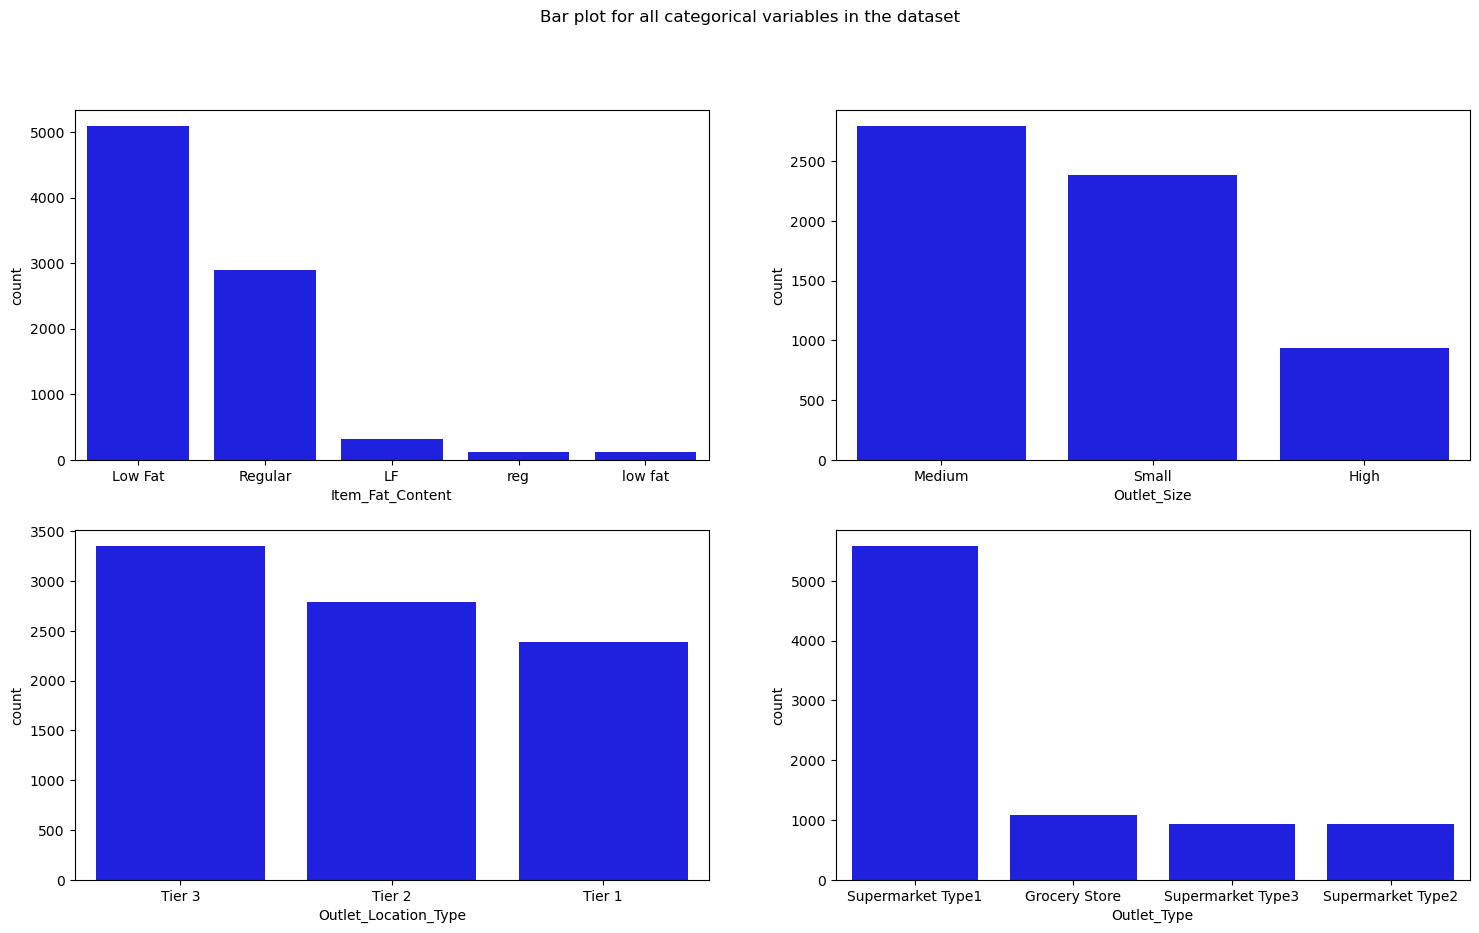

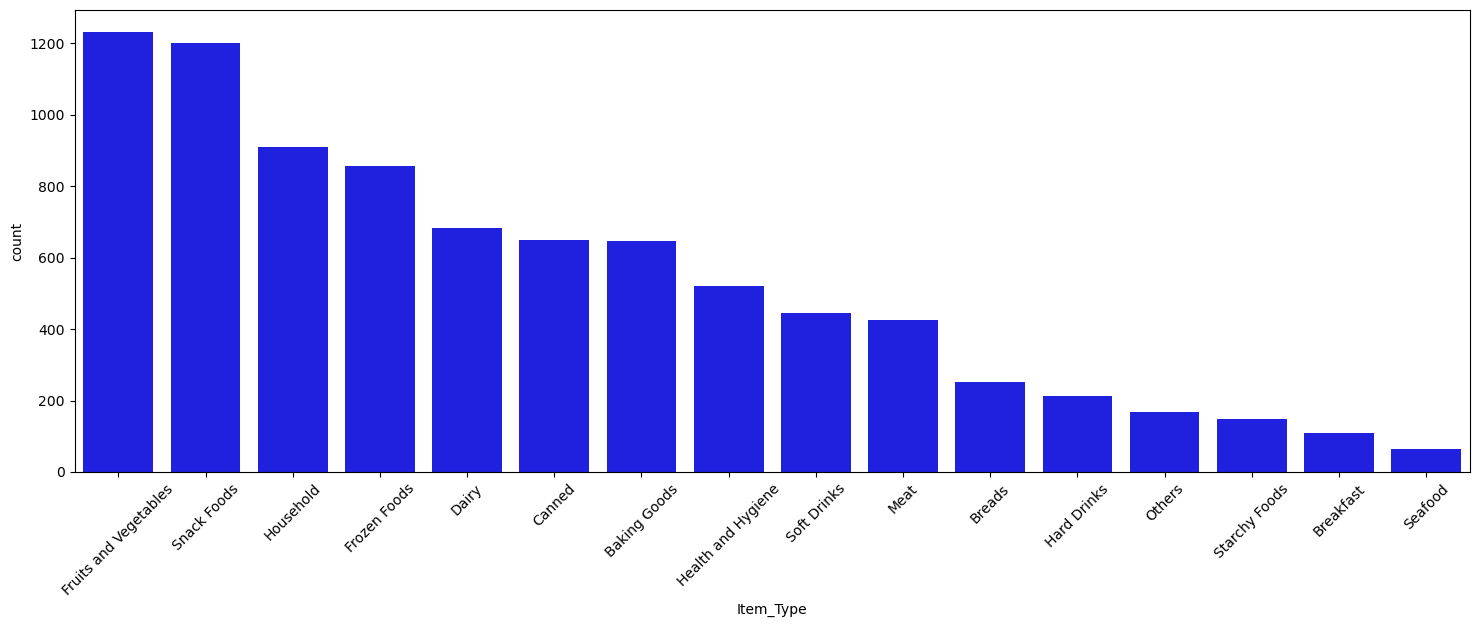

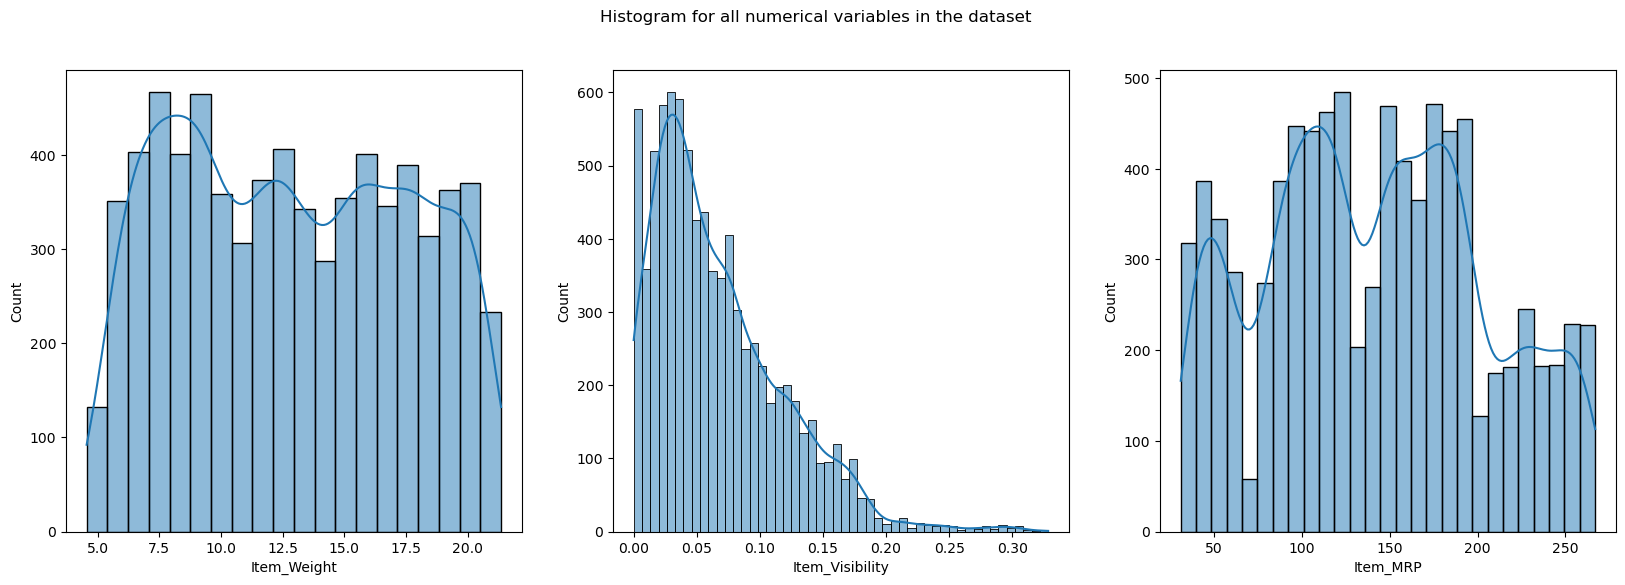

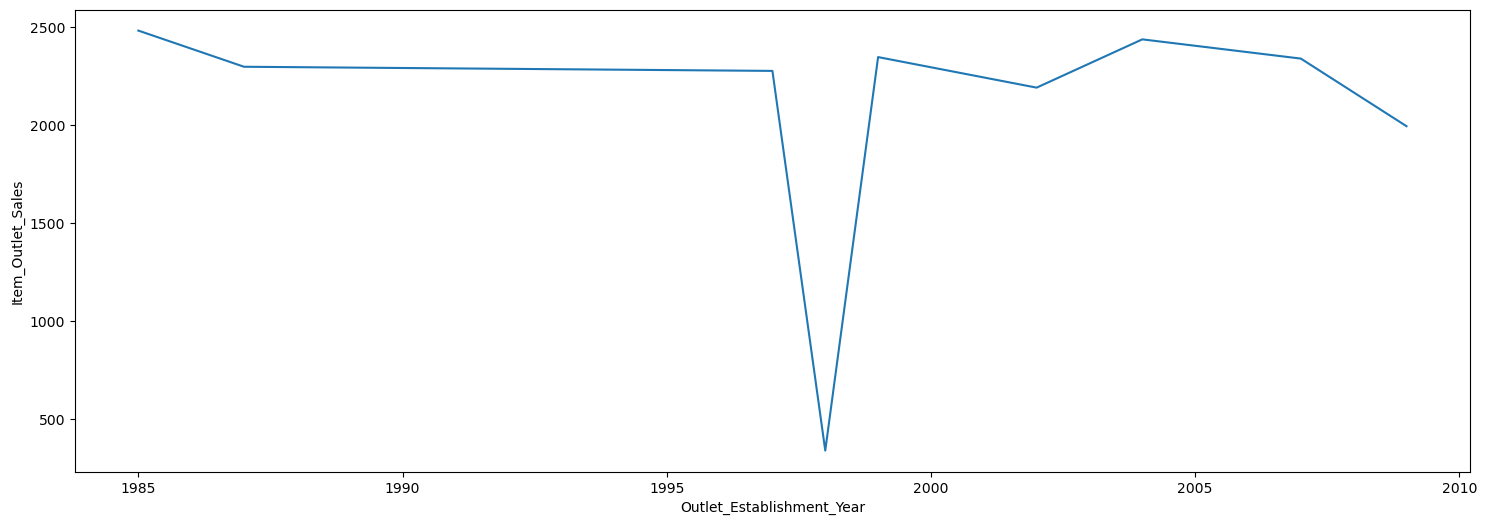

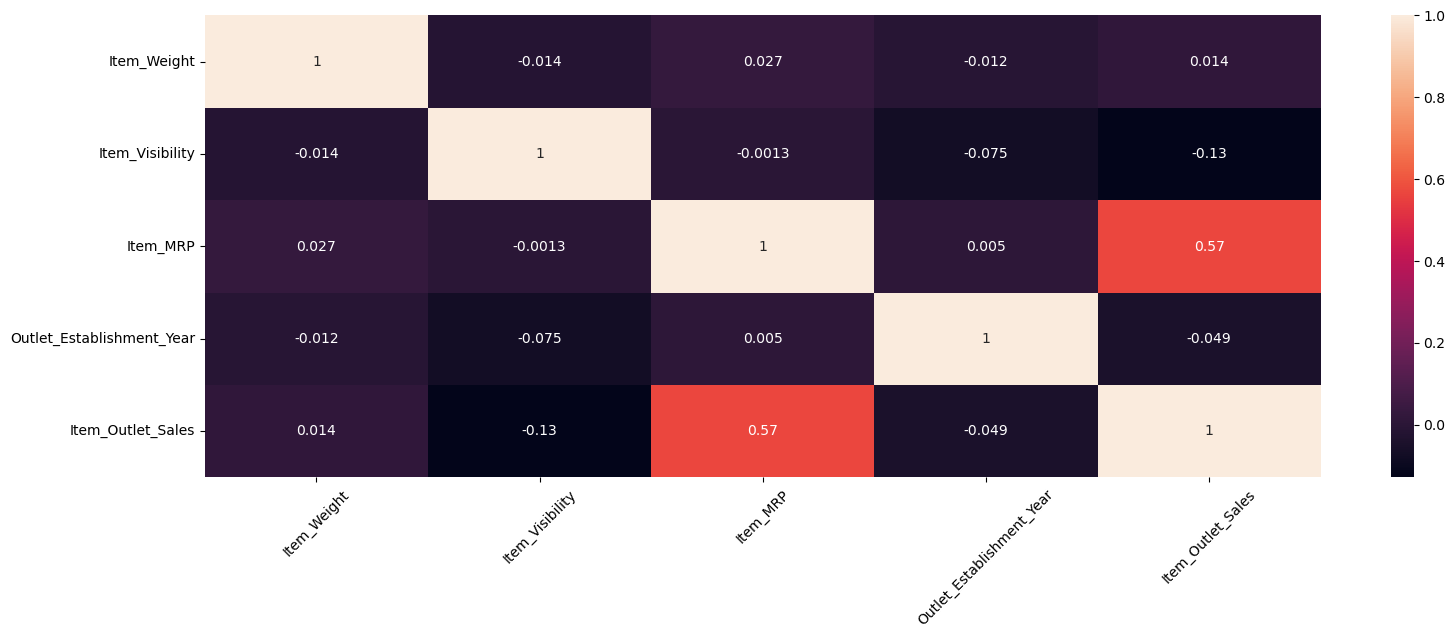

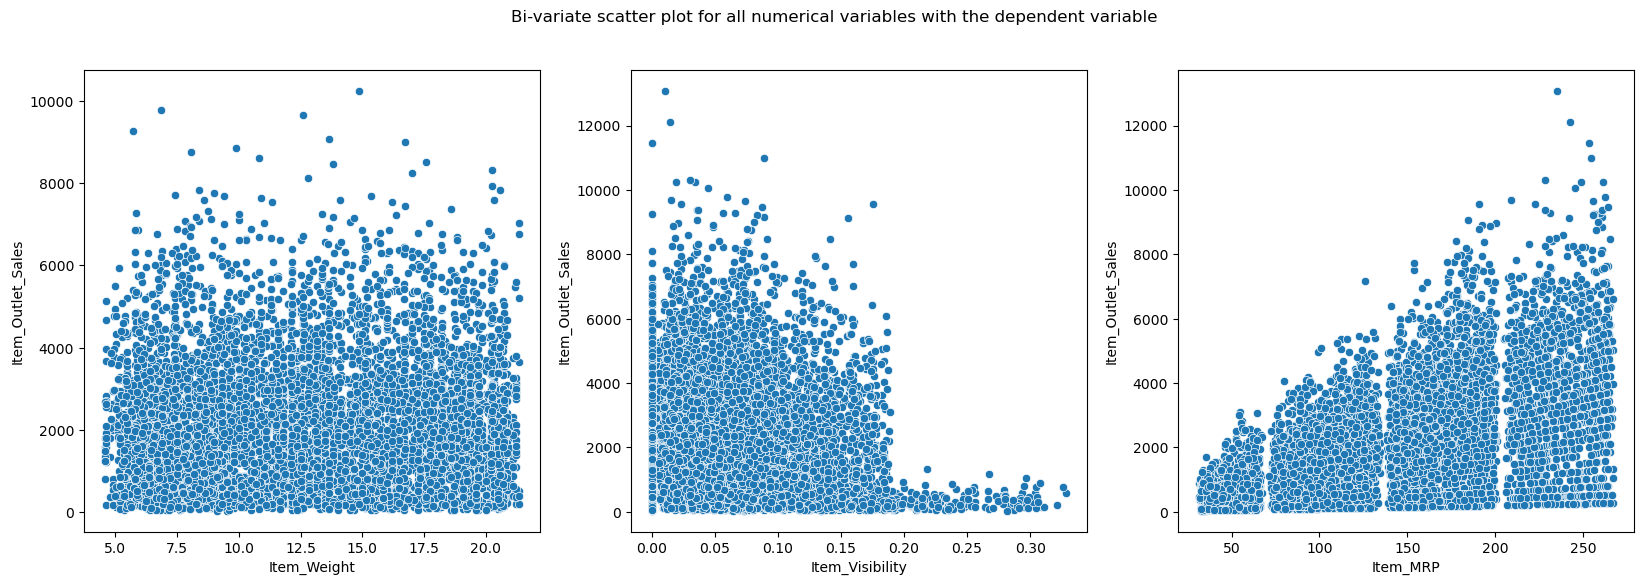

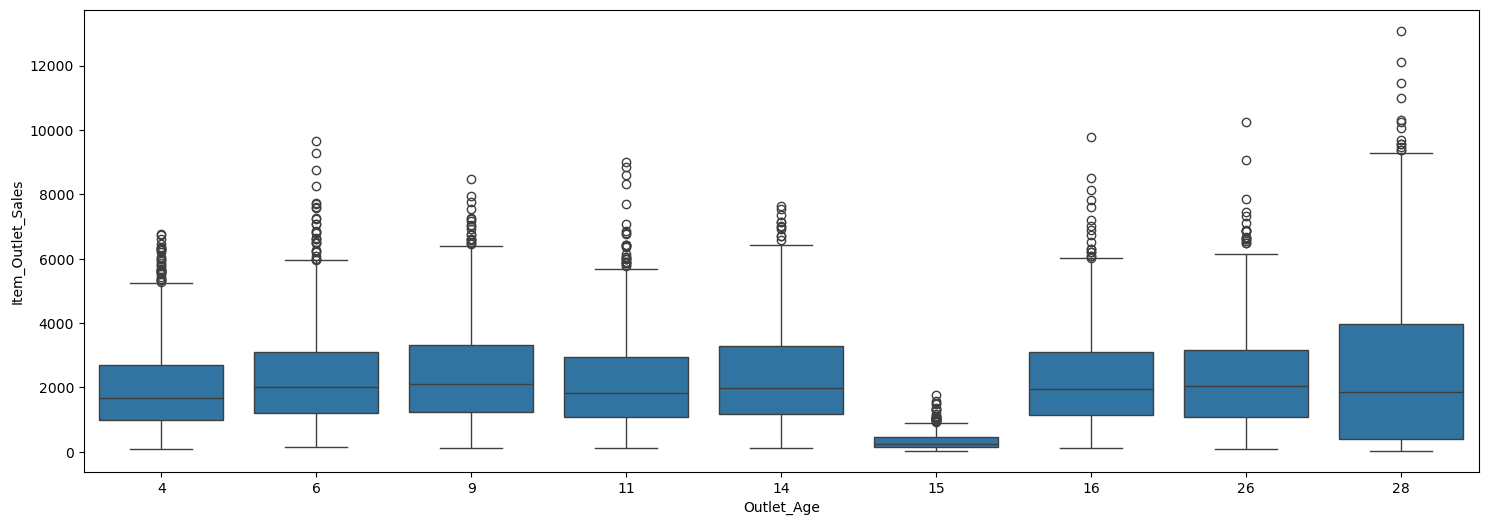

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm # type: ignore
from statsmodels.stats.outliers_influence import variance_inflation_factor # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
import warnings
warnings.filterwarnings("ignore")

train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

train_df.head()
#axis = 1 in pandas means you are operating on columns
train_df = train_df.drop (['Item_Identifier','Outlet_Identifier'], axis = 1)
test_df = test_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis = 1)

train_df.info()

#check % of missing values
(train_df.isnull().sum() / train_df.shape[0])*100

#Univariate Analysis
fig, axes = plt.subplots(2,2,figsize = (18,10))
fig.suptitle ('Bar plot for all categorical variables in the dataset')

sns.countplot (ax = axes [0,0], x='Item_Fat_Content', data = train_df, color ='blue', order = train_df['Item_Fat_Content'].value_counts().index);
sns.countplot (ax = axes [0,1], x='Outlet_Size', data = train_df, color ='blue', order = train_df['Outlet_Size'].value_counts().index);
sns.countplot (ax = axes [1,0], x='Outlet_Location_Type', data=train_df, color ='blue', order = train_df['Outlet_Location_Type'].value_counts().index);
sns.countplot (ax = axes [1,1], x='Outlet_Type', data=train_df, color ='blue', order = train_df['Outlet_Type'].value_counts().index);

fig = plt.figure(figsize = (18, 6))
sns.countplot(x = 'Item_Type', data = train_df, color = 'blue', order = train_df['Item_Type'].value_counts().index);
plt.xticks(rotation = 45);

#let's fix some data issues, for example what we see for Item_Fat_Content
train_df['Item_Fat_Content'] = train_df ['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x=='low fat' or x =='LF' else x)
train_df['Item_Fat_Content'] = train_df ['Item_Fat_Content'].apply(lambda x: 'Regular' if x=='Regular' or x =='reg' else x)

test_df['Item_Fat_Content'] = test_df ['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x=='low fat' or x =='LF' else x)
test_df['Item_Fat_Content'] = test_df ['Item_Fat_Content'].apply(lambda x: 'Regular' if x=='Regular' or x =='reg' else x)

fig, axes = plt.subplots(1, 3, figsize = (20, 6))
fig.suptitle('Histogram for all numerical variables in the dataset')
#kde stands for kernel density estimate
sns.histplot(x = 'Item_Weight', data = train_df, kde = True, ax = axes[0]);
sns.histplot(x = 'Item_Visibility', data = train_df, kde = True, ax = axes[1]);
sns.histplot(x = 'Item_MRP', data = train_df, kde = True, ax = axes[2]);
#oberservations from the 3 histograms above
#first has an approx uniform distribution, second is right skewed and third is multi modal normal distribution

#Bi-variate analysis
fig = plt.figure(figsize = (18,6))
sns.lineplot(x='Outlet_Establishment_Year', y='Item_Outlet_Sales', data=train_df, ci=None, estimator = 'mean');

#find out which variables are correlated with the target variable. Also find multi-collinearity - which pair of independent variables are correlated with each other
fig = plt.figure(figsize =(18,6))
sns.heatmap(train_df.corr(numeric_only = True), annot = True);
plt.xticks(rotation=45);

#bi-variate scatter plots
fig, axes = plt.subplots(1,3, figsize = (20,6))
fig.suptitle ('Bi-variate scatter plot for all numerical variables with the dependent variable')
sns.scatterplot(x='Item_Weight', y='Item_Outlet_Sales', data=train_df, ax = axes [0]);
sns.scatterplot(x='Item_Visibility', y='Item_Outlet_Sales', data=train_df, ax = axes [1]);
sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', data=train_df, ax = axes [2]);

#Imputing missing values for Item_Weight
item_weight_indices_to_be_updated = train_df[train_df['Item_Weight'].isnull()].index
train_df.loc[item_weight_indices_to_be_updated, 'Item_Weight'] = np.random.uniform(10, 14, len(item_weight_indices_to_be_updated))
item_weight_indices_to_be_updated = test_df[test_df['Item_Weight'].isnull()].index
test_df.loc[item_weight_indices_to_be_updated, 'Item_Weight'] = np.random.uniform(10, 14, len(item_weight_indices_to_be_updated))
#Imputing missing values for Outlet_Size
grocery_store_indices = train_df[train_df['Outlet_Size'].isnull()].query(" Outlet_Type == 'Grocery Store' ").index
tier_2_indices = train_df[train_df['Outlet_Size'].isnull()].query(" Outlet_Location_Type == 'Tier 2' ").index
train_df.loc[grocery_store_indices, 'Outlet_Size'] = 'Small'
train_df.loc[tier_2_indices, 'Outlet_Size'] = 'Small'

grocery_store_indices = test_df[test_df['Outlet_Size'].isnull()].query(" Outlet_Type == 'Grocery Store' ").index
tier_2_indices = test_df[test_df['Outlet_Size'].isnull()].query(" Outlet_Location_Type == 'Tier 2' ").index
test_df.loc[grocery_store_indices, 'Outlet_Size'] = 'Small'
test_df.loc[tier_2_indices, 'Outlet_Size'] = 'Small'

train_df.isnull().sum()
test_df.isnull().sum()

#we now start with FEATURE ENGINEERING: This is the step of creating new features from existing features.
train_df['Outlet_Age'] = 2013 - train_df['Outlet_Establishment_Year']
test_df['Outlet_Age'] = 2013 - test_df['Outlet_Establishment_Year']

fig = plt.figure(figsize=(18,6))
sns.boxplot (x='Outlet_Age', y= 'Item_Outlet_Sales', data=train_df);

#Modeling

train_features = train_df.drop(['Item_Outlet_Sales','Outlet_Establishment_Year'], axis = 1)
#extract the outcome variable
train_target = train_df ['Item_Outlet_Sales']

#create dummy variables for categorical variables
train_features = pd.get_dummies (train_features, drop_first = True)
train_features.head()

#Scaling the numerical variables
scaler = MinMaxScaler()
train_features_scaled = scaler.fit_transform (train_features)
train_features_scaled = pd.DataFrame(train_features_scaled, index = train_features.index, columns=train_features.columns)
train_features_scaled.head()

#the dataset is now ready for modeling using the statsmodel package
train_features_scaled = sm.add_constant(train_features_scaled)
ols_model_0 = sm.OLS(train_target, train_features_scaled)
ols_res_0 = ols_model_0.fit()
print(ols_res_0.summary())




